# Investigating the effect of Location on model performance.

In [148]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option("display.max_rows", None, "display.max_columns", None)

import string
import re

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer

In [149]:
data = pd.read_csv('../nlp-getting-started/train.csv', encoding='utf-8')
data.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [150]:
# drop entries with missing location
## removing entries without location entries
data5 = data.copy()
data_without_missing_locations = data.copy()
data_without_missing_locations = data_without_missing_locations.dropna(subset=['location'])
data_without_missing_locations.describe(include='all')

,id,keyword,location,text,target
count,5080.000000,5080,5080,5080,5080.000000
unique,NaN,221,3341,5028,NaN
top,NaN,collision,USA,#Bestnaijamade: 16yr old PKK suicide bomber wh...,NaN
freq,NaN,36,104,6,NaN
mean,5407.112598,NaN,NaN,NaN,0.432283
std,3116.359041,NaN,NaN,NaN,0.495442
min,48.000000,NaN,NaN,NaN,0.000000
25%,2728.750000,NaN,NaN,NaN,0.000000
50%,5360.500000,NaN,NaN,NaN,0.000000
75%,8086.000000,NaN,NaN,NaN,1.000000


## Data cleaning

In [151]:
#### removing entries where location values are missing
data_after_null_removal = data_without_missing_locations.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

# Lematizing the words
lemmatizer = WordNetLemmatizer()

def lementization(text):
    text = lemmatizer.lemmatize(text)
    return text

data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: lementization(x.lower()))


[nltk_data] Downloading package stopwords to /home/tebogo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### useful functions

In [152]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [153]:
def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1

In [154]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Without Location

In [155]:
df = data_without_tockenization.copy()

df.sample(frac=1)

sentences = df['text'].values
y = df['target'].values

In [156]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [157]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index


X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [158]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [159]:
from keras.preprocessing.sequence import pad_sequences
from keras import layers

embedding_dim = 50

# define model
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 50)           603100    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 603,621
Trainable params: 603,621
Non-trainable params: 0
_________________________________________________________________


In [160]:
history = model.fit(X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)


Epoch 1/10
258/258 [==============================] - 6s 23ms/step - loss: 0.6574 - accuracy: 0.6062 - precision: 0.9609 - recall: 0.0964 - val_loss: 0.5971 - val_accuracy: 0.7031 - val_precision: 0.8317 - val_recall: 0.4138
Epoch 2/10
258/258 [==============================] - 6s 22ms/step - loss: 0.4404 - accuracy: 0.8311 - precision: 0.8728 - recall: 0.7148 - val_loss: 0.4902 - val_accuracy: 0.7598 - val_precision: 0.7291 - val_recall: 0.7291
Epoch 3/10
258/258 [==============================] - 4s 17ms/step - loss: 0.2674 - accuracy: 0.8969 - precision: 0.9048 - recall: 0.8521 - val_loss: 0.5039 - val_accuracy: 0.7620 - val_precision: 0.7374 - val_recall: 0.7192
Epoch 00003: early stopping


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


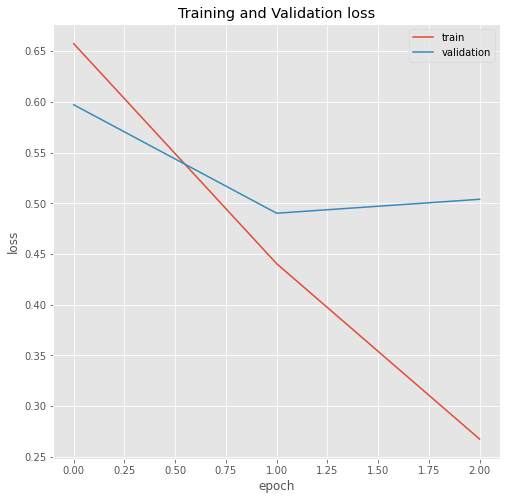

In [161]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [162]:
predictions = []
Y_pred = model.predict_generator(X_test)

    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,259,41
Positive,48,160


In [163]:
results

,Value
Accuracy,0.824803
Precision,0.796020
FPR,0.136667
Recall,0.769231
F1,0.782396


# With Location

In [164]:
df2 = data_without_tockenization.copy()

df2.sample(frac=1)

for_fitting = df2['text'].values + df2['location'].values

sentences = df2['text'].values + df2['location'].values
y = df2['target'].values

In [165]:
sentences

array(['bbcmtd wholesale markets ablaze Birmingham',
       'always try bring heavy metal rt Est. September 2012 - Bristol',
       'africanbaze breaking newsnigeria flag set ablaze aba AFRICA', ...,
       'three days work theyve pretty much wrecked hahaha shoutout family oneVancouver, Canada',
       'fx forex trading cramer igers words wrecked disneys stock London ',
       'engineshed great atmosphere british lion gig tonight hearing wrecked Lincoln'],
      dtype=object)

In [166]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [167]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index


X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [168]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [169]:
from keras.preprocessing.sequence import pad_sequences
from keras import layers

embedding_dim = 50

# define model
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 50)           810750    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 11        
Total params: 811,271
Trainable params: 811,271
Non-trainable params: 0
_________________________________________________________________


In [170]:
history = model.fit(X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)


Epoch 1/10
258/258 [==============================] - 7s 29ms/step - loss: 0.6638 - accuracy: 0.6021 - precision: 0.8895 - recall: 0.0947 - val_loss: 0.6215 - val_accuracy: 0.7183 - val_precision: 0.7984 - val_recall: 0.4877
Epoch 2/10
258/258 [==============================] - 5s 20ms/step - loss: 0.4670 - accuracy: 0.8228 - precision: 0.8848 - recall: 0.6801 - val_loss: 0.5257 - val_accuracy: 0.7227 - val_precision: 0.6759 - val_recall: 0.7192
Epoch 3/10
258/258 [==============================] - 5s 20ms/step - loss: 0.2792 - accuracy: 0.8943 - precision: 0.9023 - recall: 0.8482 - val_loss: 0.5539 - val_accuracy: 0.7031 - val_precision: 0.6667 - val_recall: 0.6601
Epoch 00003: early stopping


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


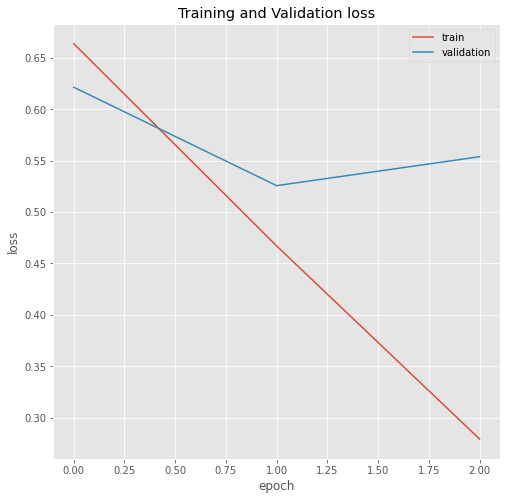

In [171]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [172]:
predictions = []
Y_pred = model.predict_generator(X_test)

    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,251,49
Positive,52,156


In [173]:
results

,Value
Accuracy,0.801181
Precision,0.760976
FPR,0.163333
Recall,0.750000
F1,0.755448


# Without Dropping rows without location entries

In [174]:
# data.head()

In [175]:
# data5 = data.copy()
# data5.head()

In [176]:
#### removing entries where location values are missing
data_after_null_removal = data5.copy()

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

# Lematizing the words
lemmatizer = WordNetLemmatizer()

def lementization(text):
    text = lemmatizer.lemmatize(text)
    return text

data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: lementization(x.lower()))


[nltk_data] Downloading package stopwords to /home/tebogo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
data_without_tockenization.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


## Without Location

In [178]:
df = data_without_tockenization.copy()

df.sample(frac=1)

sentences = df['text'].values
y = df['target'].values

In [179]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [180]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index


X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [181]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [182]:
from keras.preprocessing.sequence import pad_sequences
from keras import layers

embedding_dim = 50

# define model
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           769850    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 770,371
Trainable params: 770,371
Non-trainable params: 0
_________________________________________________________________


In [183]:
history = model.fit(X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)


Epoch 1/10
386/386 [==============================] - 9s 23ms/step - loss: 0.6040 - accuracy: 0.6865 - precision: 0.8737 - recall: 0.3101 - val_loss: 0.4857 - val_accuracy: 0.7857 - val_precision: 0.8008 - val_recall: 0.6875
Epoch 2/10
386/386 [==============================] - 9s 24ms/step - loss: 0.3649 - accuracy: 0.8522 - precision: 0.8688 - recall: 0.7700 - val_loss: 0.4595 - val_accuracy: 0.7901 - val_precision: 0.7740 - val_recall: 0.7434
Epoch 3/10
386/386 [==============================] - 8s 21ms/step - loss: 0.2461 - accuracy: 0.9020 - precision: 0.9072 - recall: 0.8582 - val_loss: 0.5000 - val_accuracy: 0.7857 - val_precision: 0.7735 - val_recall: 0.7303
Epoch 00003: early stopping


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


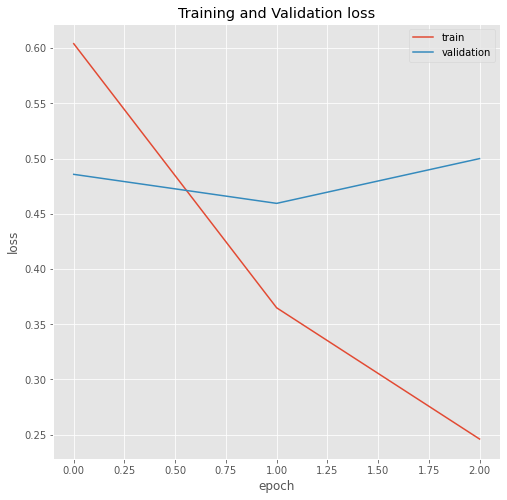

In [184]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [185]:
predictions = []
Y_pred = model.predict_generator(X_test)

    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,357,69
Positive,106,230


In [186]:
results

,Value
Accuracy,0.770341
Precision,0.769231
FPR,0.161972
Recall,0.684524
F1,0.724409


## With Location

In [190]:
data_without_tockenization.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [210]:
df = data_without_tockenization.copy()

def conc_location(text, location):
    if pd.isna(location):
        return text
    else:
        return text+location
    

df22 = df.copy()
df22['text_loc'] = df.apply(lambda x: conc_location(x.text, x.location), axis=1)
df22.head(50)

,id,keyword,location,text,target,text_loc
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,residents asked shelter place notified officer...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,got sent photo ruby alaska smoke wildfires pou...
5,8,NaN,NaN,rockyfire update california hwy closed directi...,1,rockyfire update california hwy closed directi...
6,10,NaN,NaN,flood disaster heavy rain causes flash floodin...,1,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,im top hill see fire woods,1,im top hill see fire woods
8,14,NaN,NaN,theres emergency evacuation happening building...,1,theres emergency evacuation happening building...
9,15,NaN,NaN,im afraid tornado coming area,1,im afraid tornado coming area


In [211]:
df3 = df22.copy()

df3.sample(frac=1)

sentences = df3['text_loc'].values 
y = df3['target'].values

In [217]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, test_size=0.1, random_state=42, shuffle=True)

In [218]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index


X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [219]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [220]:
from keras.preprocessing.sequence import pad_sequences
from keras import layers

embedding_dim = 50

# define model
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Precision','Recall'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           988250    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total params: 988,771
Trainable params: 988,771
Non-trainable params: 0
_________________________________________________________________


In [221]:
history = model.fit(X_train, y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)


Epoch 1/10
386/386 [==============================] - 10s 27ms/step - loss: 0.6320 - accuracy: 0.6620 - precision: 0.7145 - recall: 0.3463 - val_loss: 0.5109 - val_accuracy: 0.7872 - val_precision: 0.8624 - val_recall: 0.6184
Epoch 2/10
386/386 [==============================] - 9s 24ms/step - loss: 0.3949 - accuracy: 0.8407 - precision: 0.8593 - recall: 0.7495 - val_loss: 0.4516 - val_accuracy: 0.7872 - val_precision: 0.8062 - val_recall: 0.6842
Epoch 3/10
386/386 [==============================] - 9s 23ms/step - loss: 0.2643 - accuracy: 0.8964 - precision: 0.9129 - recall: 0.8369 - val_loss: 0.4880 - val_accuracy: 0.7813 - val_precision: 0.7692 - val_recall: 0.7237
Epoch 00003: early stopping


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


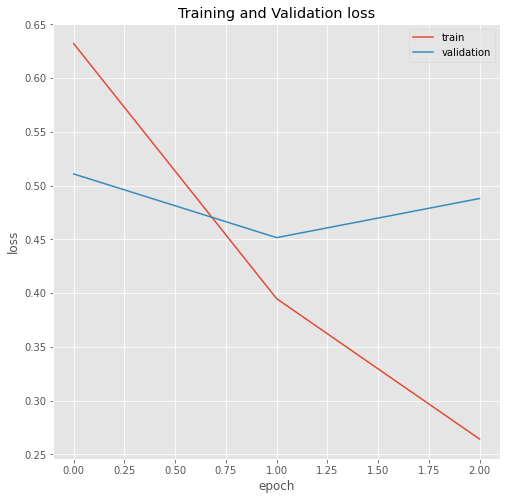

In [222]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [223]:
predictions = []
Y_pred = model.predict_generator(X_test)

    
predictions_final = [rounding(x) for x in Y_pred]

tn, fp, fn, tp = confusion_matrix(y_test, predictions_final).ravel()
precision= tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn+tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1= 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df= pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,345,81
Positive,100,236


In [224]:
results

,Value
Accuracy,0.762467
Precision,0.744479
FPR,0.190141
Recall,0.702381
F1,0.722818
